<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


## Space
The analysis we did during the workshop did not take into account physical space. If neurons near each other have more similar functional properties, and neurons near to one another are more likely to be connected, this effect might be explained just by spatial factors. How big are those effects? Can they explain this shift?

There is good evidence that synapses located close to the cell body of equal size are functionally stronger than synapses which are farther from the cell body.  

This exercise is longer and more complex than the others

In [1]:
import numpy as np
import os
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### We will start with recalculating the dataframe from the workshop

In [2]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [3]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

However this time lets make a dataframe that contains all the correlations
but also the nucleus IDs of both sides of the correlation
and then merge in the nucleus positions so we can measure the
soma to soma distance of that correlation


In [4]:
# get an array of the nucleus IDs of each row/column of the corr_M

nuc_ids = coreg_in_silico.target_id

# get the row and column indices of the upper right triangle
# of this matrix
rows, cols = np.triu_indices_from(corr_M,1)

# use the row and column indices to get an array of nucleus IDs on each side of the correlation
nuc1 = nuc_ids[rows].values
nuc2 = nuc_ids[cols].values

# use fancy indexing to pull out the correlation values
Cs = corr_M[(rows,cols)]


In [5]:

# construct a dataframe using these 3 columns
# hint use a a dictionary to name the columns
# and include "copy=False" to avoid blowing up memory
# also don't pass a 
df = pd.DataFrame({'C':Cs, 'nuc1':nuc1, 'nuc2':nuc2}, copy=False)




In [6]:
# get the nucleus positions dataframe
# converting the positions to microns
nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1,1,1])
from standard_transform.datasets import minnie_transform_nm
tform=minnie_transform_nm()
nuc_df['pt_position']=tform.apply(nuc_df.pt_position)
nuc_df['pt_position']=nuc_df.pt_position.apply(np.array)

In [7]:
# merge on the pre and post positions
dfm=df.merge(nuc_df[['id', 'pt_position']], left_on='nuc1', right_on='id')\
.drop('id', axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='nuc2', right_on='id')\
.drop('id', axis=1)

In [8]:
# visualize the first few rows of your dataframe
dfm.head()

,C,nuc1,nuc2,pt_position_x,pt_position_y
0,-0.061486,516506,452329,"[1147.312944652278, 83.90461507255363, 632.120...","[1038.4386148182793, 91.01866309021501, 735.28..."
1,-0.098622,516506,451461,"[1147.312944652278, 83.90461507255363, 632.120...","[1062.4793668418956, 73.97710441329255, 881.84..."
2,-0.140491,452329,451461,"[1038.4386148182793, 91.01866309021501, 735.28...","[1062.4793668418956, 73.97710441329255, 881.84..."
3,0.009170,516506,420222,"[1147.312944652278, 83.90461507255363, 632.120...","[1001.845527717056, 81.90669160198595, 678.960..."
4,-0.033824,452329,420222,"[1038.4386148182793, 91.01866309021501, 735.28...","[1001.845527717056, 81.90669160198595, 678.960..."


In [9]:
# measure the distance between the soma of nuc1 and nuc2

# measure the distance also in x,z only.. this is along the surface of cortex
delt_pos =np.vstack((dfm.pt_position_x-dfm.pt_position_y).values)
# hints: look at np.vstack, np.linalg.norm
dfm['soma_distance']=np.linalg.norm(delt_pos, axis=1)
dfm['cortical_distance']=np.linalg.norm(delt_pos[:,[0,2]], axis=1)

In [10]:
dfm.head()

,C,nuc1,nuc2,pt_position_x,pt_position_y,soma_distance,cortical_distance
0,-0.061486,516506,452329,"[1147.312944652278, 83.90461507255363, 632.120...","[1038.4386148182793, 91.01866309021501, 735.28...",150.153971,149.985350
1,-0.098622,516506,451461,"[1147.312944652278, 83.90461507255363, 632.120...","[1062.4793668418956, 73.97710441329255, 881.84...",263.923038,263.736259
2,-0.140491,452329,451461,"[1038.4386148182793, 91.01866309021501, 735.28...","[1062.4793668418956, 73.97710441329255, 881.84...",149.493164,148.518657
3,0.009170,516506,420222,"[1147.312944652278, 83.90461507255363, 632.120...","[1001.845527717056, 81.90669160198595, 678.960...",152.835685,152.822626
4,-0.033824,452329,420222,"[1038.4386148182793, 91.01866309021501, 735.28...","[1001.845527717056, 81.90669160198595, 678.960...",67.779233,67.163952


In [11]:
# filter out distances of <2 microns
dfm = dfm.query('soma_distance>2')

In [12]:
# using binned statistic, lets measure the avg C as a function of euclidean distance

# make up some distance bins from 2-250 microns
Dbins = np.arange(2, 250, 10)

# use scipy.stats.binned_statistic
# to measure correlation as a function of distance

mean_C, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.soma_distance,
                             values=dfm.C,
                             statistic='mean',
                             bins=Dbins)
std_C, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.soma_distance,
                             values=dfm.C,
                             statistic='std',
                             bins=Dbins)



<ErrorbarContainer object of 3 artists>

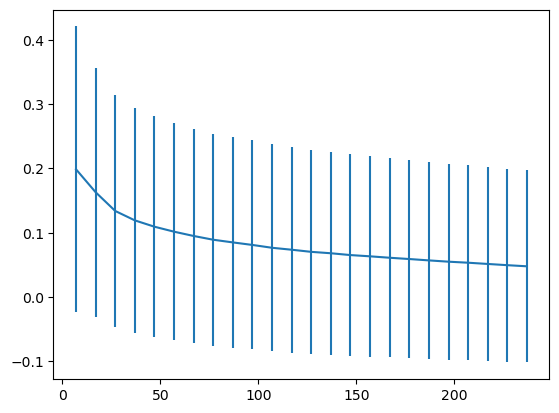

In [15]:
# what about using the cortical distance

# use the same bins

# use scipy.stats.binned_statistic
# to measure correlation as a function of distance

mean_C_cort, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.cortical_distance,
                             values=dfm.C,
                             statistic='mean',
                             bins=Dbins)
std_C_cort, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.cortical_distance,
                             values=dfm.C,
                             statistic='std',
                             bins=Dbins)



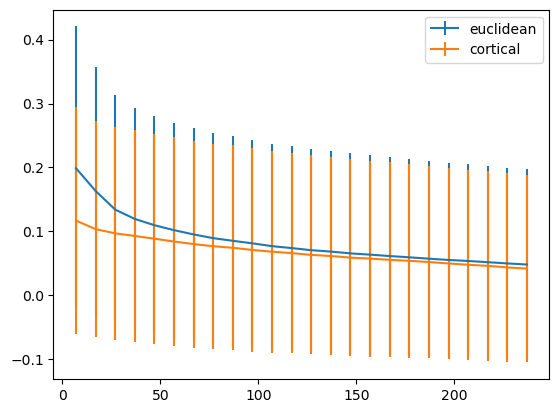

In [17]:
# make a plot of mean Correlation and std error bars a function of distance
# put both distances on same plot
f, ax=plt.subplots()

ax.errorbar(bin_centers, mean_C, std_C)
ax.errorbar(bin_centers, mean_C_cort, std_C_cort)
ax.legend(['euclidean', 'cortical'])

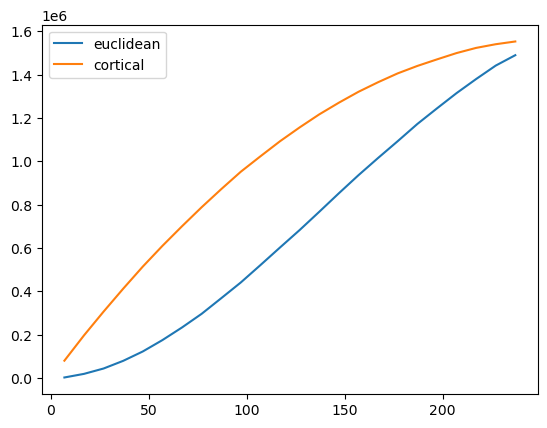

In [18]:
# make a plot of how many pairs fall in each of these distance bins
count_C, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.soma_distance,
                             values=dfm.C,
                             statistic='count',
                             bins=Dbins)
count_C_cort, bin_edges, dbin=scipy.stats.binned_statistic(x=dfm.cortical_distance,
                             values=dfm.C,
                             statistic='count',
                             bins=Dbins)
f, ax=plt.subplots()

ax.plot(bin_centers, count_C)
ax.plot(bin_centers, count_C_cort)
ax.legend(['euclidean', 'cortical'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Thought question

What explains these curves? 

In [19]:
# make the same plot but for connected pairs of neurons
# first lets reconstruct the dataframe from the workshop
# we need this code to work in solutions directory
# and one up..
if 'solutions' in os.getcwd():
    workshop2file = '../../workshop2/all_prf_coreg_conn_v661.pkl'
else:
    workshop2file = '../workshop2/all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]



In [20]:
# lets cut the dataframe down to just the columns we need
df_conn=all_syn_dfm2[['pre_nuc_id', 'post_nuc_id', 'n_syn', 'sum_size', 'C', 'pre_pt_position', 'post_pt_position']]

In [21]:
df_conn.head()

,pre_nuc_id,post_nuc_id,n_syn,sum_size,C,pre_pt_position,post_pt_position
0,265045,303145,1,1732,0.169119,"[643.0300065048364, 427.88641564546697, 884.36...","[667.8080332150954, 489.8015688177371, 890.640..."
1,299091,303145,1,7604,0.010837,"[709.1922761459178, 345.01749614037846, 895.20...","[667.8080332150954, 489.8015688177371, 890.640..."
2,292685,303145,1,23668,0.192392,"[728.1902267066858, 144.7592334831523, 840.840...","[667.8080332150954, 489.8015688177371, 890.640..."
4,256576,303145,1,9404,0.040026,"[618.4397512164188, 125.9061074383746, 881.280...","[667.8080332150954, 489.8015688177371, 890.640..."
5,222998,303145,2,25900,0.145264,"[600.9084008376958, 131.6961825586517, 919.880...","[667.8080332150954, 489.8015688177371, 890.640..."


In [25]:
# calculate the intersoma distance
d_vec=np.vstack((df_conn.pre_pt_position-df_conn.post_pt_position).values)
df_conn['soma_distance']=np.linalg.norm(d_vec, axis=1)
df_conn['cortical_distance']=np.linalg.norm(d_vec[:,[0,2]], axis=1)


/tmp/ipykernel_19105/792173319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conn['soma_distance']=np.linalg.norm(d_vec, axis=1)
/tmp/ipykernel_19105/792173319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conn['cortical_distance']=np.linalg.norm(d_vec[:,[0,2]], axis=1)


In [26]:
# filter out the soma distances of <2 microns
# to discount the double roi cells
df_conn=df_conn.query('soma_distance>2')

In [27]:
# use scipy.stats.binned_statistic
# to measure correlation as a function of distance for connected

mean_C_connected, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.soma_distance,
                             values=df_conn.C,
                             statistic='mean',
                             bins=Dbins)
std_C_connected, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.soma_distance,
                             values=df_conn.C,
                             statistic='std',
                             bins=Dbins)
mean_C_connected_cort, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.cortical_distance,
                             values=df_conn.C,
                             statistic='mean',
                             bins=Dbins)
std_C_connected_cort, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.cortical_distance,
                             values=df_conn.C,
                             statistic='std',
                             bins=Dbins)


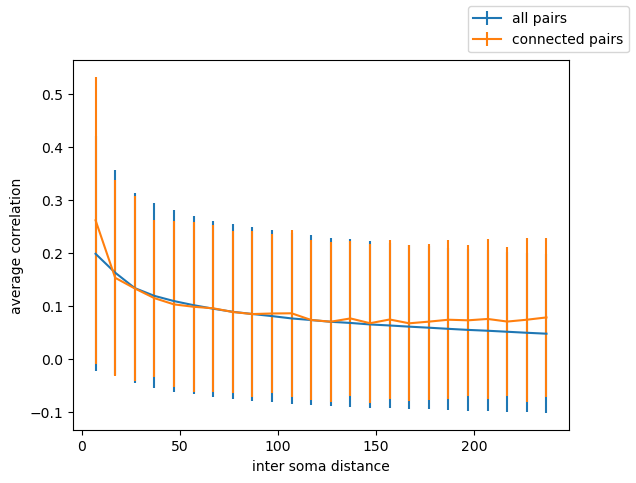

In [88]:
#  plot both curves for connected and all paris on top of one another
# make a plot of mean Correlation and std error bars a function of distance
f, ax=plt.subplots()


ax.errorbar(bin_centers, mean_C, std_C)
ax.errorbar(bin_centers, mean_C_connected, std_C_connected)

ax.set_xlabel('inter soma distance')
ax.set_ylabel('average correlation')
f.legend(['all pairs', 'connected pairs'])

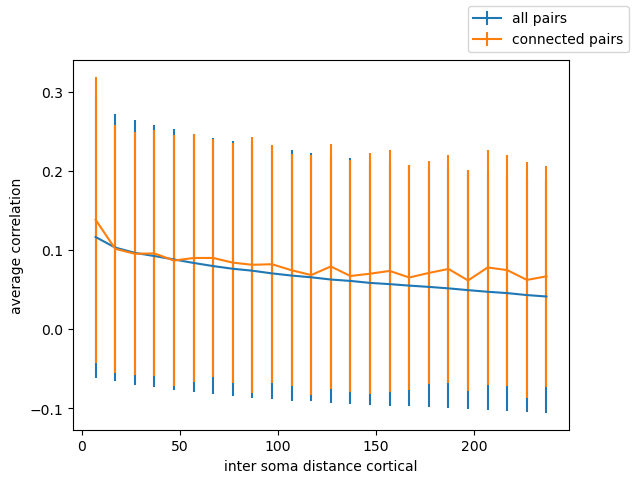

In [28]:
#  plot both curves for connected and all paris on top of one another
# make a plot of mean Correlation and std error bars a function of distance
f, ax=plt.subplots()

ax.errorbar(bin_centers, mean_C_cort, std_C_cort)
ax.errorbar(bin_centers, mean_C_connected_cort, std_C_connected_cort)

ax.set_xlabel('inter soma distance cortical')
ax.set_ylabel('average correlation')
f.legend(['all pairs', 'connected pairs'])

Text(0, 0.5, 'frequency of connected pairs')

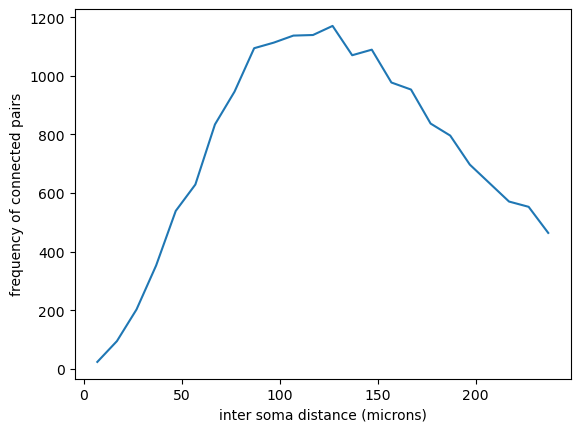

In [91]:
# plot how many connected pairs are in each distance bin
count_connected, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.soma_distance,
                             values=df_conn.C,
                             statistic='count',
                             bins=Dbins)

f, ax = plt.subplots()
ax.plot(bin_centers, count_connected)
ax.set_xlabel('inter soma distance (microns)')
ax.set_ylabel('frequency of connected pairs')

Text(0, 0.5, 'frequency of connected pairs')

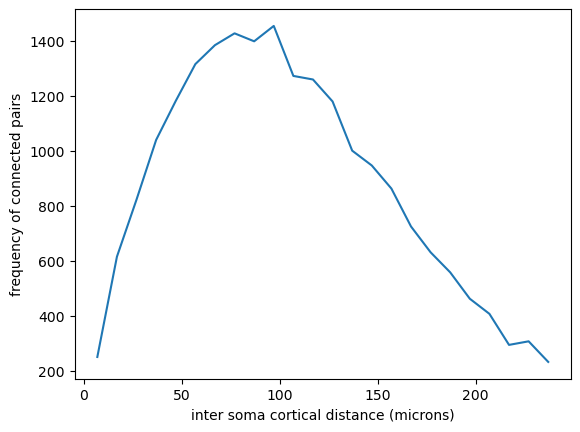

In [31]:
# plot how many are connected in a cortical distance bin
count_connected, bin_edges, dbin=scipy.stats.binned_statistic(x=df_conn.cortical_distance,
                             values=df_conn.C,
                             statistic='count',
                             bins=Dbins)

f, ax = plt.subplots()
ax.plot(bin_centers, count_connected)
ax.set_xlabel('inter soma cortical distance (microns)')
ax.set_ylabel('frequency of connected pairs')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Thought questions

What explains the difference between this curve and the overall distribution of pairs of recorded ROIs? 

Does this curve match your expectation for what cortical connectivity should look like?

If space explains a lot of the differences between connected and unconnected pairs,
what does that mean?

How does it affect your interpretation of the effects?

Are there spatial effects that go beyond just soma to soma distance that would be important to control for in order to interpret a finding as being evidence for a particular mechanism?

#### Extensions/Project Ideas

Can you make a model which resamples the all pairs to match the spatial distributions found in the connected dataset?  Are the results significant compared to that null model?

</div>